In [28]:
!pip install sentence-transformers chromadb -q

In [29]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
import chromadb

In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quora/question-pairs-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/question-pairs-dataset


In [31]:
import pandas as pd
import os

# List files in the downloaded directory
files = os.listdir(path)
print("Files in the dataset directory:", files)

# Assuming the CSV file is named "questions.csv" based on the dataset name.
# If the file name is different, you might need to adjust this line.
csv_file_path = os.path.join(path, "questions.csv")

# Check if the file exists before attempting to read
if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
    display(df.head())
else:
    print(f"Error: {csv_file_path} not found in the downloaded directory.")

Files in the dataset directory: ['questions.csv']


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [32]:
import re
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r"<[^>]+>", " ", text)  # remove html
    text = re.sub(r"\[math\](.*?)\[/math\]", lambda m: m.group(1), text, flags=re.DOTALL)
    text = text.replace("^", "**")
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["q1_clean"] = df["question1"].astype(str).apply(clean_text)
df["q2_clean"] = df["question2"].astype(str).apply(clean_text)

In [33]:
all_qs = pd.concat([
    df[["qid1","q1_clean"]].rename(columns={"qid1":"qid","q1_clean":"text"}),
    df[["qid2","q2_clean"]].rename(columns={"qid2":"qid","q2_clean":"text"})
], ignore_index=True)

all_qs = all_qs.drop_duplicates(subset=["text"]).reset_index(drop=True)
all_qs["doc_id"] = [f"doc_{x}" for x in all_qs.index]

# mapping for lookup
mapping = all_qs.set_index("doc_id")[["qid","text"]].to_dict(orient="index")

print("Unique questions:", len(all_qs))
all_qs.head()

Unique questions: 537346


,qid,text,doc_id
0,1,What is the step by step guide to invest in sh...,doc_0
1,3,What is the story of Kohinoor (Koh-i-Noor) Dia...,doc_1
2,5,How can I increase the speed of my internet co...,doc_2
3,7,Why am I mentally very lonely? How can I solve...,doc_3
4,9,"Which one dissolve in water quikly sugar, salt...",doc_4


In [34]:
subset_size = 500
all_qs = all_qs.head(subset_size)

In [35]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [36]:

model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")


In [37]:
texts = all_qs["text"].tolist()
embeddings = model.encode(texts, batch_size=32, show_progress_bar=True, convert_to_numpy=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [43]:
np.save("embeddings_partial.npy", embeddings)
all_qs.to_csv("unique_questions.csv", index=False)

In [38]:
client = chromadb.Client()
collection = client.get_or_create_collection("questions")

collection.add(
    ids = all_qs["doc_id"].tolist(),
    documents = all_qs["text"].tolist(),
    metadatas = all_qs[["qid"]].to_dict(orient="records"),
    embeddings = embeddings.tolist()
)
print("Collection size:", collection.count())

Collection size: 500


In [39]:
collection.configuration_json

{'hnsw': {'space': 'l2',
  'ef_construction': 100,
  'ef_search': 100,
  'max_neighbors': 16,
  'resize_factor': 1.2,
  'sync_threshold': 1000},
 'spann': None,
 'embedding_function': {'type': 'known', 'name': 'default', 'config': {}}}

In [40]:
def semantic_search(query, top_k=5, rerank=False):
    q_emb = model.encode(query).tolist()
    res = collection.query(query_embeddings=[q_emb], n_results=top_k)
    docs = res["documents"][0]
    ids = res["ids"][0]
    metadatas = res["metadatas"][0]
    scores = res.get("distances", [[]])[0]

    hits = [{"id": ids[i], "text": docs[i], "meta": metadatas[i], "score": scores[i] if scores else None} for i in range(len(docs))]

    if rerank:
        from sentence_transformers import CrossEncoder
        cross = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')
        pairs = [[query, h["text"]] for h in hits]
        rerank_scores = cross.predict(pairs)
        for i,h in enumerate(hits):
            h["rerank"] = rerank_scores[i]
        hits = sorted(hits, key=lambda x: x["rerank"], reverse=True)
    return hits

# مثال:
print(semantic_search("How to invest in shares step by step?", top_k=3, rerank=True))


[{'id': 'doc_0', 'text': 'What is the step by step guide to invest in share market in india?', 'meta': {'qid': 1}, 'score': 0.4680565595626831, 'rerank': np.float32(3.8296561)}, {'id': 'doc_248', 'text': 'What is the best way to invest $500 legally so that I can get tangible profits over a relatively short period of time, say 6 months?', 'meta': {'qid': 497}, 'score': 0.9573484659194946, 'rerank': np.float32(-9.139425)}, {'id': 'doc_346', 'text': 'How do we start a business?', 'meta': {'qid': 695}, 'score': 1.1743096113204956, 'rerank': np.float32(-11.126957)}]


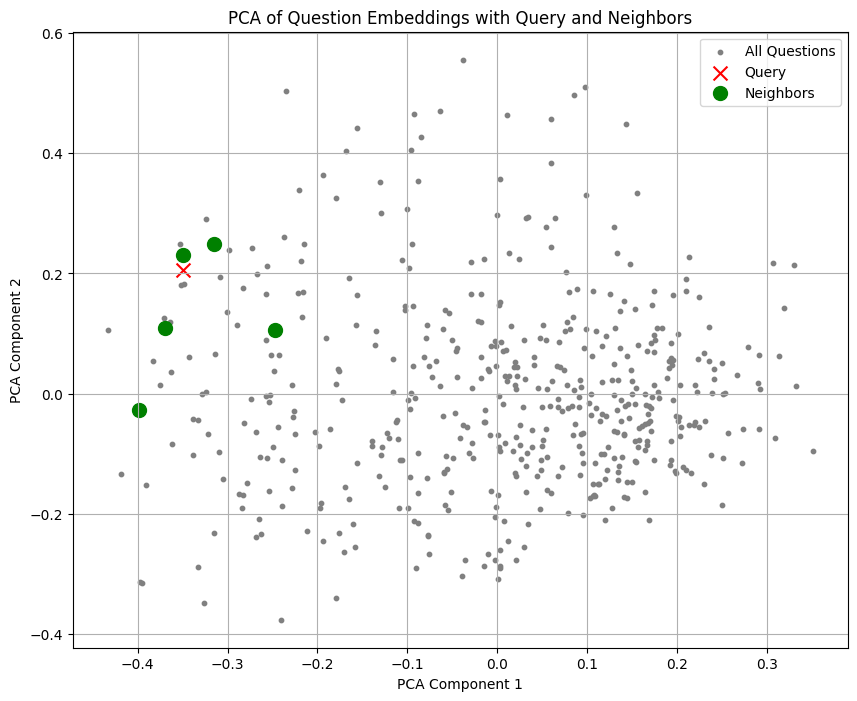

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming embeddings_2d from the previous PCA cell is available
# Assuming search_results from the previous similarity search cell is available
# Assuming model and pca objects from previous cells are available

# Reduce the query embedding to 2 dimensions using the *same* PCA object
query_embedding_2d = pca.transform(query_embedding)

# Get the IDs of the retrieved neighbors
neighbor_ids = [result['id'] for result in semantic_search(query_question, top_k=5)] # Using the semantic_search function to get neighbor IDs

# Find the indices of the neighbors in the original all_qs DataFrame
neighbor_indices = all_qs[all_qs['doc_id'].isin(neighbor_ids)].index

# Get the 2D embeddings of the neighbors
neighbor_embeddings_2d = embeddings_2d[neighbor_indices]

plt.figure(figsize=(10, 8))

# Plot all embeddings in gray
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, color='gray', label='All Questions')

# Plot the query embedding in red with an 'x' marker
plt.scatter(query_embedding_2d[:, 0], query_embedding_2d[:, 1], s=100, color='red', marker='x', label='Query')

# Plot the neighbor embeddings in green with 'o' markers
plt.scatter(neighbor_embeddings_2d[:, 0], neighbor_embeddings_2d[:, 1], s=100, color='green', marker='o', label='Neighbors')

plt.title('PCA of Question Embeddings with Query and Neighbors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend()
plt.show()

In [42]:
# Define a query question
query_question = "How to invest in stocks?"

# Encode the query question using the same model
query_embedding = model.encode([query_question], convert_to_numpy=True)

# Perform a similarity search in the collection
# n_results specifies the number of similar documents to retrieve
search_results = collection.query(
    query_embeddings=query_embedding.tolist(),
    n_results=5,
    include=['documents', 'metadatas', 'distances']
)

# Display the search results
print(f"Search results for: '{query_question}'")
for i, (doc, meta, dist) in enumerate(zip(search_results['documents'][0], search_results['metadatas'][0], search_results['distances'][0])):
    print(f"{i+1}. Document: {doc}")
    print(f"   Metadata: {meta}")
    print(f"   Distance: {dist}")

Search results for: 'How to invest in stocks?'
1. Document: What is the step by step guide to invest in share market in india?
   Metadata: {'qid': 1}
   Distance: 0.6760276556015015
2. Document: What is the best way to invest $500 legally so that I can get tangible profits over a relatively short period of time, say 6 months?
   Metadata: {'qid': 497}
   Distance: 0.8659172058105469
3. Document: How can I become a billionaire?
   Metadata: {'qid': 637}
   Distance: 1.150323510169983
4. Document: Who is the richest gambler of all time and how can I reach his level?
   Metadata: {'qid': 149}
   Distance: 1.2039790153503418
5. Document: What is the easiest way to become a billionaire($)?
   Metadata: {'qid': 401}
   Distance: 1.2512396574020386
